In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem


from sklearn import linear_model

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 81) 
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 60)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 28)]
    
    test_data = test123.iloc[[0, 1, 3]] #It allows to get 3 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data):
    
    X = data[features['molecular descriptor name']]
    
    y = data['Aktywność cytoprotekcyjna [%]']
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, y)
    
    pred = regr.predict(X)
    print("R^2 score: "+ str(r2_score(y, pred)))
    sqrt_r2 = np.sqrt(r2_score(y, pred))
    training_data_r2 = r2_score(y, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = regr.predict(test_data[features['molecular descriptor name']])
    print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
    sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(test_data['Aktywność cytoprotekcyjna [%]']) 
    test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])

    return regr, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:01<00:00, 34.92it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 22.50it/s]


(44, 1613)
(44, 1433)
(44, 1182)


In [10]:
without_standarization, train_r2, test_r2, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.3, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455        

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


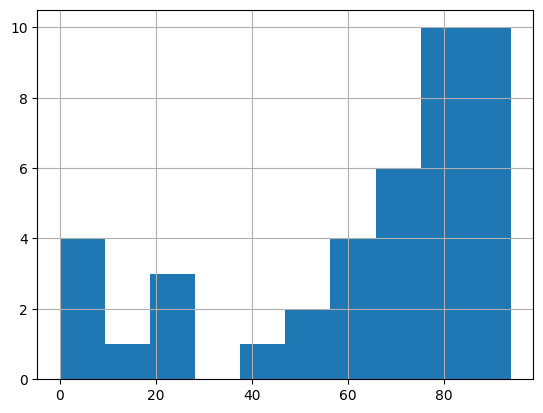

In [11]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [12]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 21


In [13]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
137,AATSC3c,-0.319623,0.319623
455,BCUTare-1h,0.323770,0.323770
456,BCUTare-1l,0.345707,0.345707
468,BCUTp-1l,-0.321204,0.321204
469,BCUTpe-1h,0.317690,0.317690
476,BCUTv-1l,-0.325136,0.325136
520,ETA_dEpsilon_D,0.412783,0.412783
566,GATS3c,0.308343,0.308343
614,GATS7c,0.310103,0.310103
706,MATS3c,-0.317344,0.317344


In [14]:
with_standarization, train_r2, test_r2, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.3, True)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


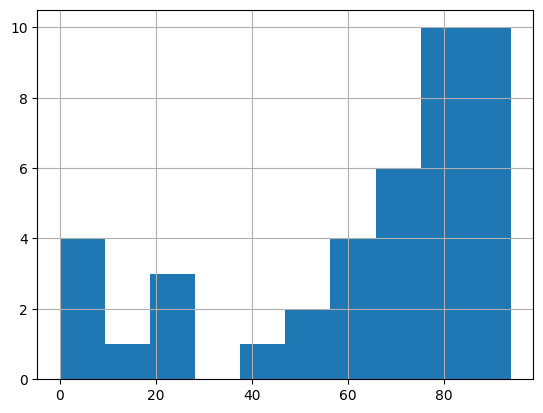

In [15]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [16]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 21


In [17]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
137,AATSC3c,-0.319623,0.319623
455,BCUTare-1h,0.323770,0.323770
456,BCUTare-1l,0.345707,0.345707
468,BCUTp-1l,-0.321204,0.321204
469,BCUTpe-1h,0.317690,0.317690
476,BCUTv-1l,-0.325136,0.325136
520,ETA_dEpsilon_D,0.412783,0.412783
566,GATS3c,0.308343,0.308343
614,GATS7c,0.310103,0.310103
706,MATS3c,-0.317344,0.317344


## Search inside correlation space

In [18]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53         

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

In [19]:
df_without_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])

In [20]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list

In [21]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,1.000000,-10.304877,46
1,0.26,0.986019,-1.110403,38
2,0.27,0.872962,-1.683300,30
3,0.28,0.854640,-4.289543,28
4,0.29,0.819227,-25.756042,26
5,0.30,0.670380,-8.294618,21
6,0.31,0.589590,-7.555962,20
7,0.32,0.461991,-1.382891,15
8,0.33,0.403505,-0.282021,12
9,0.34,0.300203,0.133589,9


In [22]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, True)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
45                   AATS4are    0.257682                    0.257682
53                    AATS4se    0.265626                    0.265626
85                     AATS7s    0.254720                    0.254720
101                   AATSC0c    0.264307                    0.264307
12

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
53                    AATS4se    0.265626                    0.265626
101                   AATSC0c    0.264307                    0.264307
125                   AATSC2c    0.260430                    0.260430
137                   AATSC3c   -0.319623                    0.319623
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
367                    ATSC3c   -0.273000                    0.273000
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
40

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
401                    ATSC6Z    0.282292                    0.282292
455                BCUTare-1h    0.323770                    0.323770
45

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
392                    ATSC5d    0.291862                    0.291862
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
137                   AATSC3c   -0.319623                    0.319623
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
46

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
455                BCUTare-1h    0.323770                    0.323770
456                BCUTare-1l    0.345707                    0.345707
468                  BCUTp-1l   -0.321204                    0.321204
476                  BCUTv-1l   -0.325136                    0.325136
52

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            ETA_dEpsilon_D    0.412783                    0.412783
829                     NaaNH    0.386873                    0.386873
831                      NaaS   -0.343855                    0.343855
89

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
899                      SaaNH    0.359872                    0.359872
1126                   n6HRing    0.362058                    0.3620

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
     molecular descriptor name  corr_value  absolute correlation value
520             ETA_dEpsilon_D    0.412783                    0.412783
829                      NaaNH    0.386873                    0.386873
1126                   n6HRing    0.362058                    0.362058
1128                  n6aHRing    0.362527                    0.3625

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
829                           NaaNH    0.386873                    0.386873
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000 

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
          molecular descriptor name  corr_value  absolute correlation value
520                  ETA_dEpsilon_D    0.412783                    0.412783
1160                         nHBDon    0.394681                    0.394681
1182  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
     molecular descriptor name  corr_value  abso

In [23]:
df_with_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])
df_with_standarization['Training data R^2 score'] = second_list
df_with_standarization['Test data R^2 score'] = third_list
df_with_standarization['Number of features'] = f_list

In [24]:
df_with_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,1.000000,-0.301297,46
1,0.26,0.986019,-1.110403,38
2,0.27,0.872962,-1.683300,30
3,0.28,0.854640,-4.289543,28
4,0.29,0.819227,-25.756042,26
5,0.30,0.670380,-8.294618,21
6,0.31,0.589590,-7.555962,20
7,0.32,0.461991,-1.382891,15
8,0.33,0.403505,-0.282021,12
9,0.34,0.300203,0.133589,9


## Plots

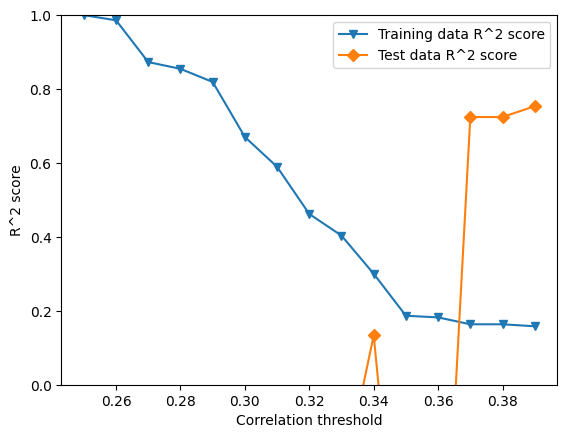

In [25]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Training data R^2 score'], label = "Training data R^2 score", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Test data R^2 score'], label = "Test data R^2 score", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R^2 score')
plt.ylim([0, 1])
plt.show()

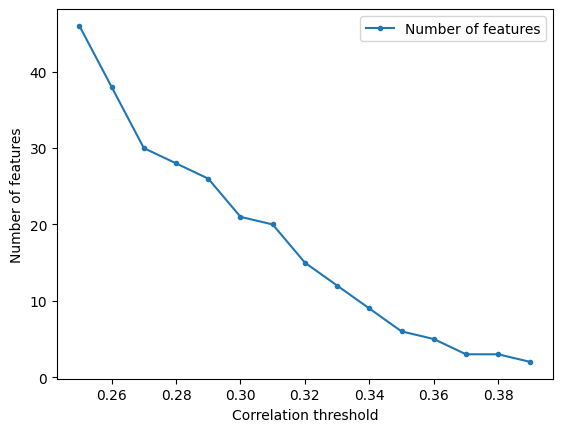

In [26]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

# sqrt(R^2)

In [27]:
df_without_standarization['train R value'] = [np.sqrt(x) for x in df_without_standarization['Training data R^2 score']]

In [28]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,train R value
0,0.25,1.000000,-10.304877,46,1.000000
1,0.26,0.986019,-1.110403,38,0.992985
2,0.27,0.872962,-1.683300,30,0.934324
3,0.28,0.854640,-4.289543,28,0.924467
4,0.29,0.819227,-25.756042,26,0.905112
5,0.30,0.670380,-8.294618,21,0.818767
6,0.31,0.589590,-7.555962,20,0.767848
7,0.32,0.461991,-1.382891,15,0.679700
8,0.33,0.403505,-0.282021,12,0.635221
9,0.34,0.300203,0.133589,9,0.547908


In [29]:
xcz = []
for element in df_without_standarization['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2727130492.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [30]:
xcz

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.36549775301467463,
 0,
 0,
 0.851048184591871,
 0.851048184591871,
 0.8680487599209604]

In [31]:
df_without_standarization['test R value'] = xcz

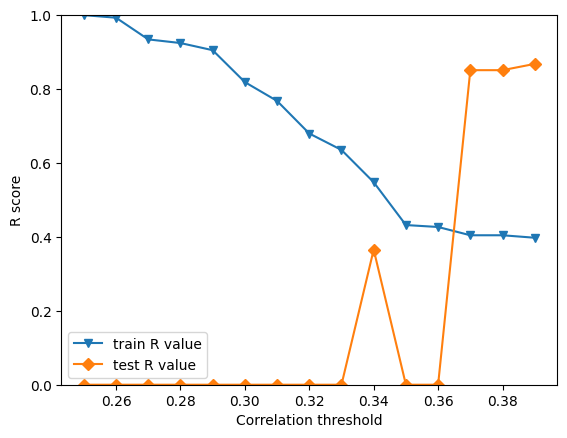

In [32]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['train R value'], label = "train R value", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

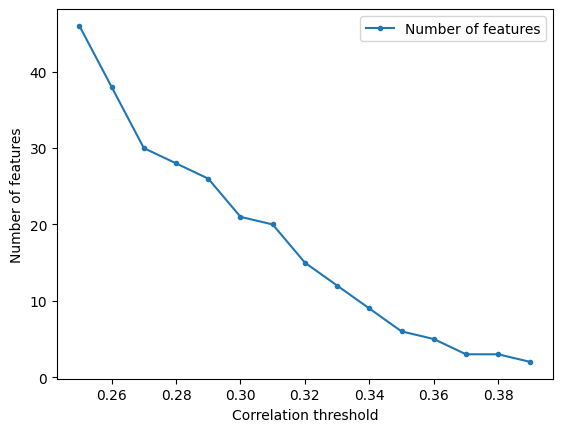

In [33]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [34]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520        

C:\Users\aleks\AppData\Local\Temp\ipykernel_16160\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [35]:
final_model[0].get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [36]:
final_model[0].intercept_

-11078.833830727126

In [37]:
final_model[0].coef_

array([ 5.11328085e+03,  3.11166249e+02,  5.12555997e+01,  3.16888609e+00,
       -1.22555922e+01,  5.30336238e+00,  5.86685770e-01, -1.02829371e-03,
        3.98709262e-02, -4.34959806e+00,  4.94220782e+00, -2.72214515e+00])

## Build equation

In [38]:
final_model[4]

,molecular descriptor name,corr_value,absolute correlation value
456,BCUTare-1l,0.345707,0.345707
520,ETA_dEpsilon_D,0.412783,0.412783
829,NaaNH,0.386873,0.386873
831,NaaS,-0.343855,0.343855
899,SaaNH,0.359872,0.359872
901,SaaS,-0.343855,0.343855
913,SlogP_VSA1,0.338615,0.338615
1030,VR1_A,-0.339451,0.339451
1040,VR2_A,-0.339146,0.339146
1126,n6HRing,0.362058,0.362058


In [39]:
names = list(final_model[4]['molecular descriptor name'])
print("The model's equation is: ")
for i in range(len(names)):
    print(str(final_model[0].coef_[i])+str(' * ')+str(names[i]))
    
print(str(final_model[0].intercept_))

The model's equation is: 
5113.280846973232 * BCUTare-1l
311.166248719037 * ETA_dEpsilon_D
51.255599705174994 * NaaNH
3.1688860943292223 * NaaS
-12.25559218457937 * SaaNH
5.303362380399831 * SaaS
0.5866857699081249 * SlogP_VSA1
-0.0010282937133787114 * VR1_A
0.039870926223796954 * VR2_A
-4.349598063856892 * n6HRing
4.942207818573698 * n6aHRing
-2.722145152952592 * nHBDon
-11078.833830727126


## Predict target feature

In [40]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

  9%|███████                                                                          | 78/891 [00:02<00:14, 55.31it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 12%|█████████▌                                                                      | 107/891 [00:02<00:13, 59.45it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 13%|██████████▌                                                                     | 118/891 [00:03<00:14, 53.86it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 15%|████████████▎                                                                   | 137/891 [00:03<00:11, 64.92it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 30%|███████████████████████▌                                                        | 263/891 [00:04<00:06, 94.53it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 56%|████████████████████████████████████████████▊                                   | 499/891 [00:07<00:05, 77.41it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 61.70it/s]


(891, 1613)
(891, 1226)
(891, 1100)


In [41]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [42]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [43]:
print(len(smiles))
print(len(predicted_activity))

891
891


In [44]:
save_to_df.head()

,SMILES
0,CCOCc1cn(C(C)=O)c2ccccc12
1,CC(=O)n1cc(COc2ccccc2)c2ccccc21
2,C=C(C)n1cc(CO)c2ccccc21
3,CC(=O)n1cc(CCO)c2ccccc21
4,c1ccc2c(c1)c1cn2CCCCOC1


In [45]:
save_to_df['Predicted activity'] = predicted_activity

In [46]:
save_to_df.head()

,SMILES,Predicted activity
0,CCOCc1cn(C(C)=O)c2ccccc12,46.682702
1,CC(=O)n1cc(COc2ccccc2)c2ccccc21,49.525092
2,C=C(C)n1cc(CO)c2ccccc21,53.535199
3,CC(=O)n1cc(CCO)c2ccccc21,52.819437
4,c1ccc2c(c1)c1cn2CCCCOC1,46.718251


In [47]:
save_to_df.to_excel('../Data/Predicted_activity.xlsx')